We consider a utility maximization problem with the following model specifications: $L_M$, $L_F$ denotes hours worked by male and female respectively. $w_M$, $w_F$ is the wages for the workers. Hours worked at home are given by $H_M$, $H_F$. 

Consumption of market goods must satisfy the budget constraint, i.e.:

$$
C = w_ML_M+w_FL_f
$$

## Import of packages

In [2]:
# a. import
import ipywidgets as widgets
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import HouseholdSpecializationModel
from HouseholdSpecializationModel import HouseholdSpecializationModelClass
mo = HouseholdSpecializationModelClass()

## Question 1: Illustrate how $H_F/H_M$ changes when varying $\alpha$ and $\sigma$ 

In [3]:
# Define the values of alpha and sigma to use
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1, 1.5]
mo = HouseholdSpecializationModelClass()
results_dict = {} # dictionary for storing the results

#Loop over all combinations of alpha and sigma values and find each solution
for alpha in alpha_values:
    for sigma in sigma_values:
        mo.par.alpha = alpha
        mo.par.sigma = sigma
        res = mo.solve_discrete()
        results_dict[alpha, sigma] = round(res.HF/ res.HM,3) #save dictionary for later use
table = [list(results_dict.keys()),list(results_dict.values())] #table
from tabulate import tabulate
print(tabulate(table, tablefmt='fancy_grid')) #formating and print


╒═════════════╤═══════════╤═════════════╤════════════╤══════════╤════════════╤═════════════╤═══════════╤═════════════╕
│ (0.25, 0.5) │ (0.25, 1) │ (0.25, 1.5) │ (0.5, 0.5) │ (0.5, 1) │ (0.5, 1.5) │ (0.75, 0.5) │ (0.75, 1) │ (0.75, 1.5) │
├─────────────┼───────────┼─────────────┼────────────┼──────────┼────────────┼─────────────┼───────────┼─────────────┤
│ 0.545       │ 0.308     │ 0.214       │ 1.0        │ 1.0      │ 1.0        │ 1.833       │ 3.25      │ 4.667       │
╘═════════════╧═══════════╧═════════════╧════════════╧══════════╧════════════╧═════════════╧═══════════╧═════════════╛


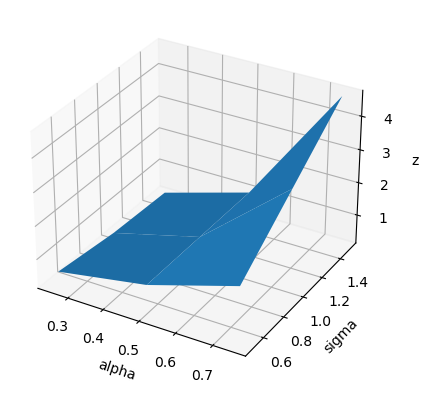

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# We plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert alpha and sigma values to a meshgrid for plotting
alpha_mesh, sigma_mesh = np.meshgrid(alpha_values, sigma_values)
z_mesh = np.array([results_dict[alpha, sigma] for alpha, sigma in zip(np.ravel(alpha_mesh), np.ravel(sigma_mesh))])
z_mesh = z_mesh.reshape(alpha_mesh.shape)

# Plot the surface
ax.plot_surface(alpha_mesh, sigma_mesh, z_mesh)
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('z')
plt.show()

## Question 2: plot $log H_F/H_M$ against $log w_F/w_M$ for $w_F \in [0.8, 0.9, 1, 1.1, 1.2]$


[2.0794415416798357, 1.6094379124341003, 1.540445040947149, 1.540445040947149, 1.466337068793427]


Text(0, 0.5, 'log ($H_F$ / $H_M$)')

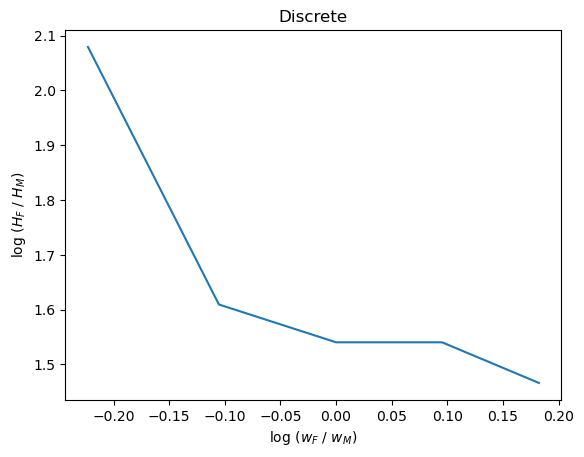

In [32]:
#Find HF/HM for every value of sigma:
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
wM = 1.0
Log_ratio = []
import math
for wF in wF_values:
    mo.par.wF = wF
    mo.par.wM = wM
    opt = mo.solve_discrete()
    Log_ratio.append(math.log(opt.HF/opt.HM))
print(Log_ratio)

# Plot HF/HM relation against every wF/wM relation 
plt.plot(np.log(wF_values), Log_ratio)
plt.title('Discrete')
plt.xlabel('log ($w_F$ / $w_M$)')
plt.ylabel('log ($H_F$ / $H_M$)')



## Question 3: Continously

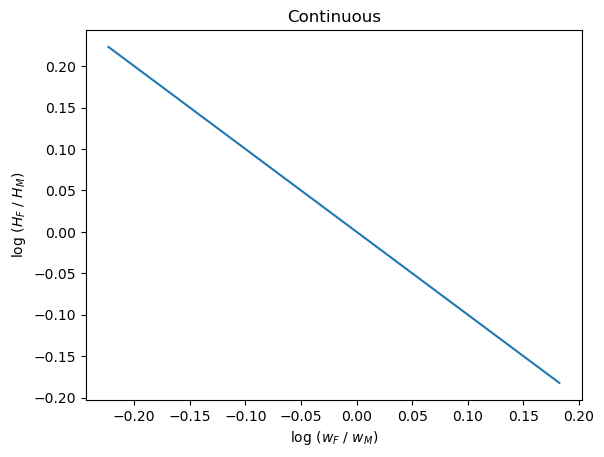

In [33]:
# Relation between WF and WM
mo.par.alpha = 0.5
mo.par.sigma = 1
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
HF_HM_c = np.empty(5)
wF_wM_c = np.empty(5)

#Continuous:
for i, wF in enumerate(mo.par.wF_vec):
    mo.par.wF = wF
    opt = mo.solve_con()

    HF_HM_c[i] = np.log(opt.HF/opt.HM)
    wF_wM_c[i] = np.log(mo.par.wF/mo.par.wM)
        
#Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Continuous')
ax.plot(wF_wM_c, HF_HM_c)
ax.set_xlabel("log ($w_F$ / $w_M$)")
ax.set_ylabel("log ($H_F$ / $H_M$)")
plt.show()


## Question 4: Choose $\alpha$ and $\sigma$ such that it minimizes $(\beta_0-\hat{\beta}_0)^2+(\beta_1-\hat{\beta}_1)^2$. Illustrate how the model fit the data and discuss the economic interpretation of the results. 

/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  H = ((1-par.alpha)*HM**sigma_ + (par.alpha)*HF**sigma_)**((sigma_)**-1)
/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:68: RuntimeWarning: overflow encountered in double_scalars
  H = ((1-par.alpha)*HM**sigma_ + (par.alpha)*HF**sigma_)**((sigma_)**-1)
/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:71: RuntimeWarning: invalid value encountered in double_scalars
  Q = C**par.omega*H**(1-par.omega)


Squared errors are minimized if alpha is 0.982 and sigma is 0.100
Then the coefficients of beta are, beta1: -0.100 and beta0: 0.400 and consequently the minimized squared error is 0.000.


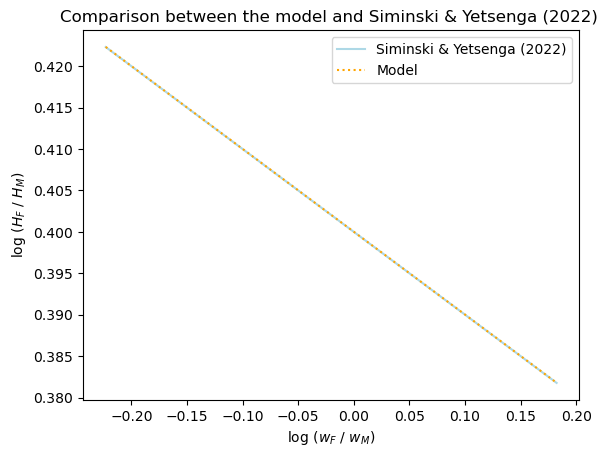

In [34]:
results = mo.estimate()
alpha = mo.par.alpha
sigma = mo.par.sigma
error = results.error
import matplotlib.pyplot as plt
import numpy as np

# b. The alpha and sigma values that minimizes the squared error
print(f'Squared errors are minimized if alpha is {mo.par.alpha:.3f} and sigma is {mo.par.sigma:.3f}')
print (f'Then the coefficients of beta are, beta1: {mo.sol.beta1:.3f} and beta0: {mo.sol.beta0:.3f} and consequently the minimized squared error is {results.error:.3f}.')


# Creating a plot of the relation that Siminski and Yetsenga
#  and the estimated model
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
HF_HM_c = np.empty(5)
wF_wM_c = np.empty(5)
reg_plot = np.empty(5)

for i, wF in enumerate(mo.par.wF_vec):
    mo.par.wF = wF
    opt = mo.solve_con()

    HF_HM_c[i] = np.log(opt.HF/opt.HM)
    wF_wM_c[i] = np.log(mo.par.wF/mo.par.wM)
    reg_plot[i] = 0.4 - 0.1*wF_wM_c[i]

#plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Comparison between the model and Siminski & Yetsenga (2022) ')
ax.plot(wF_wM_c, reg_plot, label = 'Siminski & Yetsenga (2022)', color="lightblue", linestyle= "-", alpha= 1)
ax.plot(wF_wM_c, HF_HM_c, label = 'Model', color = 'orange', linestyle = ':', alpha=1)
ax.set_xlabel("log ($w_F$ / $w_M$)")
ax.set_ylabel("log ($H_F$ / $H_M$)")
plt.legend()
plt.show()


From the figure it can be seen that we get the same results as Siminski & Yetsenga (2022).

## Question 5

In [35]:
# we start by resetting the epsilon-value
mo.par.epsilon = 1

# run baseline model
results = mo.estimation_extended(extended=False)

print(f'Squared errors are minimized if alpha is {mo.par.alpha:.3f} and sigma is {float(mo.par.sigma):3f}.')
print (f'Then the coefficients of beta are, beta1: {mo.sol.beta1:.3f} and beta0: {mo.sol.beta0:.3f} and consequently the minimized squared error is {results.error:.3f}.')


Squared errors are minimized if alpha is 0.500 and sigma is 0.099902.
Then the coefficients of beta are, beta1: -0.100 and beta0: 0.000 and consequently the minimized squared error is 0.160.
